In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchviz import make_dot, make_dot_from_trace
from utils import *
from solver import train
from data_loader import SRCNN_dataset

# HOW TO INSTALL PYTORCHVIZ
!pip install git+https://github.com/szagoruyko/pytorchviz

In [2]:
class SRCNN(nn.Module):
    """
    Model for SRCNN

    Input -> Conv1 -> Relu -> Conv2 -> Relu -> Conv3 -> MSE
    
    Args:
        - C1, C2, C3: num output channels for Conv1, Conv2, and Conv3
        - F1, F2, F3: filter size
    """
    def __init__(self,
                 C1=64, C2=32, C3=1,
                 F1=9, F2=1, F3=5):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, C1, F1) # in, out, kernel
        self.conv2 = nn.Conv2d(C1, C2, F2)
        self.conv3 = nn.Conv2d(C2, C3, F3)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [3]:
%matplotlib inline
train_config = { 'dir_path': 'Train', 'scale': 3, 'is_gray': True, 'input_size': 33, 'label_size': 21, 'stride': 21 }
test_config = train_config.copy()
test_config['dir_path'] = 'Test/Set5'

train_dataset = SRCNN_dataset(train_config)
model = SRCNN()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model = train(train_dataset, model, loss_fn, optimizer, num_epochs=1, batch_size=128)

/home/wazir/Desktop/NIAZ/SRCNN_Pytorch/solver.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  %(epoch + 1, i, loss.data[0]))


Epoch 1, iter     0, loss 0.28441
Epoch 1, iter    10, loss 0.19197
Epoch 1, iter    20, loss 0.14433
Epoch 1, iter    30, loss 0.09211
Epoch 1, iter    40, loss 0.03468
Epoch 1, iter    50, loss 0.01035
Epoch 1, iter    60, loss 0.01074
Epoch 1, iter    70, loss 0.01042


In [4]:
torch.save(model, 'niazmodel.pth')

/home/wazir/.virtualenvs/wazir/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SRCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [5]:
summary(model, (1, 33,33)) # SAME NUMBER OF PARAMETERS AS CALCULATED IN KERAS

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 25]           5,248
            Conv2d-2           [-1, 32, 25, 25]           2,080
            Conv2d-3            [-1, 1, 21, 21]             801
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 0.03
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


In [6]:
model = torch.load('niazmodel.pth')

In [7]:
summary(model, (1, 33,33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 25]           5,248
            Conv2d-2           [-1, 32, 25, 25]           2,080
            Conv2d-3            [-1, 1, 21, 21]             801
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 0.03
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


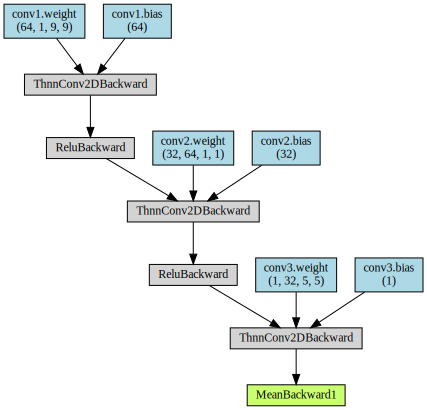

In [8]:
x = Variable(torch.randn(1,1,33,33))
y = model(x)
make_dot(y.mean(),params=dict(model.named_parameters()))

In [9]:
print(model)

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
)


In [10]:
import torch
from torch.autograd import Variable
%matplotlib inline

paths = get_image_paths('Test/Set5')
image = imread(paths[1])
test_sample, test_label = process_image(image)
h, w = test_sample.shape
print(h, w)
test_input = test_sample.reshape(1, h, w, 1)
test_input = test_input.transpose(0, 3, 1, 2)
test_input = torch.Tensor(test_input)
test_input = Variable(test_input)
test_output = model(test_input)

test_output = test_output.data.numpy()
test_output = test_output[0].transpose(1, 2, 0)
h, w = test_output.shape[0], test_output.shape[1]
test_output = test_output.reshape(h, w)

255 255


In [11]:
print(test_output.shape)

(243, 243)


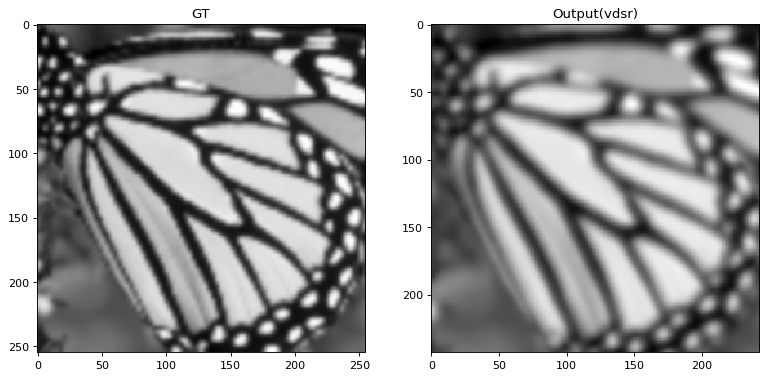

In [12]:
# Result visualization
fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(test_sample,cmap='gray')
ax.set_title("GT")

ax = plt.subplot("132")
ax.imshow(test_output,cmap='gray')
ax.set_title("Output(vdsr)")
plt.show()